In [1]:
from Bio import SeqIO
from itertools import cycle
import warnings
import numpy as np
from dna_features_viewer import GraphicFeature, GraphicRecord, BiopythonTranslator
import matplotlib.pyplot as plt
from copy import deepcopy

In [2]:
seq = SeqIO.read("<path_to>/sars2_refseq.gb",'genbank')

In [3]:
seq.id

'NC_045512.2'

In [3]:
X_CODONS =  set(["AAC","AAT","ACC","ATC","ATT","CAG","CTC","CTG","GAA","GAC","GAG","GAT","GCC","GGC","GGT",
                 "GTA","GTC","GTT","TAC","TTC"])

In [5]:
def x_motif(x):
    frame_open = 0
    frame_score = 0
    codon_set = set()
    if len(x)%3 != 0:
        warnings.warn("This sequence is not divisible by 3 and will be truncated by {} bases.".format(len(x)%3))
    for i in range(0,len(x)-(len(x)%3),3):
        if x[i:i+3] in X_CODONS:
            frame_open += 3
            codon_set.update([x[i:i+3]])
        elif frame_open > 6 and len(codon_set) > 1:
            frame_score += frame_open
            frame_open = 0
            codon_set = set()
        else:
            frame_open = 0
            codon_set = set()
    else:
        #flush frame_open buffer once end of loop is reached
        #without this last X motif in sequence is never counted
        if frame_open > 6 and len(codon_set) > 1:
            frame_score += frame_open
    return frame_score

In [6]:
x_motif(str(seq.seq[2:]))

1524

In [8]:
#rewrite get_scores to only do a sliding window withing the give reading frame takes as argument complete sequence
#and intervals dict
def get_scores(seq,interval_dict,window_size=150):
    scores_dict = {frame:np.zeros(len(range(frame,len(seq)-window_size,3))) for frame in interval_dict.keys()}
    for frame in interval_dict.keys():
        for interval in interval_dict[frame]:
            for i in range(interval[0],interval[1]-window_size,3):
                scores_dict[frame][i//3] = x_motif(seq[i:i+window_size])
    return scores_dict
    

In [11]:
#(10950, 11088)
10950//3

3650

In [12]:
#(265, 13483)
265//3

88

In [14]:
4//3

1

In [10]:
len(range(2,len(seq)-150,3))

9917

In [3]:
list(range(0,150,3))

[0,
 3,
 6,
 9,
 12,
 15,
 18,
 21,
 24,
 27,
 30,
 33,
 36,
 39,
 42,
 45,
 48,
 51,
 54,
 57,
 60,
 63,
 66,
 69,
 72,
 75,
 78,
 81,
 84,
 87,
 90,
 93,
 96,
 99,
 102,
 105,
 108,
 111,
 114,
 117,
 120,
 123,
 126,
 129,
 132,
 135,
 138,
 141,
 144,
 147]

In [9]:
def find_orfs(seq, min_length=120):
    """
    Find ORFs in all three forward reading frames of a nucleotide sequence.
    """
    seq = seq.upper()
    stop_codons = {'TAA', 'TAG', 'TGA'}
    start_codon = 'ATG'
    orfs = {0: [], 1: [], 2: []}

    for frame in range(3):
        i = frame
        while i < len(seq) - 2:
            codon = seq[i:i+3]
            if codon == start_codon:
                start = i
                j = i + 3
                while j < len(seq) - 2:
                    stop_codon = seq[j:j+3]
                    if stop_codon in stop_codons:
                        end = j + 3  # include stop codon
                        if end - start >= min_length:
                            orfs[frame].append((start, end))
                        break
                    j += 3
                i = j  # jump to the end of the ORF or next codon after failed ORF
            else:
                i += 3
    return orfs

In [9]:
#TODO: In order to do XME normalization, we will take the intervals generated in orf_list and perform a bedtools coverage operation
#with the -d flag to give per-base coverage. This allows normalization of the gofix scores on a per-coordinate basis for overlapping orfs

In [10]:
orf_list = find_orfs(str(seq.seq))

In [11]:
orf_list

{0: [(10950, 11088),
  (13767, 21555),
  (25392, 26220),
  (26244, 26472),
  (27201, 27387),
  (27393, 27759)],
 1: [(265, 13483),
  (15460, 15667),
  (16972, 17122),
  (19147, 19303),
  (21535, 25384),
  (25456, 25582),
  (26692, 26872),
  (28273, 29533)],
 2: [(725, 881),
  (965, 1097),
  (1604, 1739),
  (2957, 3206),
  (3611, 3752),
  (3947, 4103),
  (4706, 4835),
  (5918, 6089),
  (6155, 6350),
  (7547, 7709),
  (9980, 10115),
  (10214, 10400),
  (13310, 13466),
  (21743, 21863),
  (21935, 22199),
  (24050, 24170),
  (25523, 25697),
  (26522, 27191),
  (27755, 27887),
  (27893, 28259),
  (28283, 28577),
  (28733, 28955)]}

In [12]:
'''
frame_array = np.zeros(len(seq))
for frame in orf_list:
    for intervals in orf_list[frame]:
        new_orf = np.zeros(len(seq))
        new_orf[intervals[0]:intervals[1]] += 1
        frame_array = frame_array + new_orf
'''

In [12]:
frame_array = {}
for frame in orf_list:
    new_orf = np.zeros(len(seq))
    for intervals in orf_list[frame]:
        new_orf[intervals[0]:intervals[1]] += 1
    frame_array[frame] = new_orf


In [13]:
frame_array[0]

array([0., 0., 0., ..., 0., 0., 0.])

In [14]:
#TODO: Get scores by iterating through intervals list instead of full sequence
window_size = 150
raw_scores = get_scores(str(seq.seq),orf_list,window_size)

In [15]:
print(len(raw_scores[0]))
print(len(raw_scores[1]))
print(len(raw_scores[2]))

9918
9918
9917


In [25]:
frame_set = set([0,1,2])
print(frame_set - set([1]))

{0, 2}


In [16]:
gofix_scores = {}
frame_set = set([0,1,2])
lf_debug = []
array_range = min([len(raw_scores[f]) for f in raw_scores.keys()])
for frame in raw_scores:
    new_score = []
    #Score is XL_f
    for i,score in enumerate(range(array_range)):
        #Need to calculate l_f
        l_f = window_size
        for other_frame in frame_set - set([frame]):
            l_f -= raw_scores[other_frame][i] * np.max(frame_array[other_frame][(i*3)+other_frame:(i*3)+window_size])
        new_score.append((100/l_f)*raw_scores[frame][i])
        lf_debug.append(l_f)
    gofix_scores[frame] = np.array(new_score)
        

In [17]:
100/min(lf_debug)

1.5151515151515151

In [18]:
gofix_scores[0]

array([0., 0., 0., ..., 0., 0., 0.])

In [62]:
np.where(frame_array[0] !=0)

(array([10950, 10951, 10952, ..., 27756, 27757, 27758], dtype=int64),)

In [19]:
seq.features = [f for f in seq.features if f.type == 'CDS']

In [50]:
feature_frames = {f.qualifiers['gene'][0]:f.location.start%3 for f in seq.features}

In [51]:
feature_frames

{'ORF1ab': 1,
 'S': 1,
 'ORF3a': 0,
 'E': 0,
 'M': 2,
 'ORF6': 0,
 'ORF7a': 0,
 'ORF7b': 2,
 'ORF8': 2,
 'N': 1,
 'ORF10': 1}

In [64]:
color_dict = {0:'#f14722',1:'#26deba',2:'#dd7cee'}

In [20]:
#graphic_record = BiopythonTranslator().translate_record("C:/Users/notor/Documents/Phil_School_2024/Phil_School_2024/Seto_lab_rotation/sars2_refseq.gb")
graphic_record = BiopythonTranslator().translate_record(seq)


In [65]:
for gf in graphic_record.features:
    gf.color = color_dict[feature_frames[gf.label]]

In [61]:
graphic_record.features[0].label

'ORF1ab'

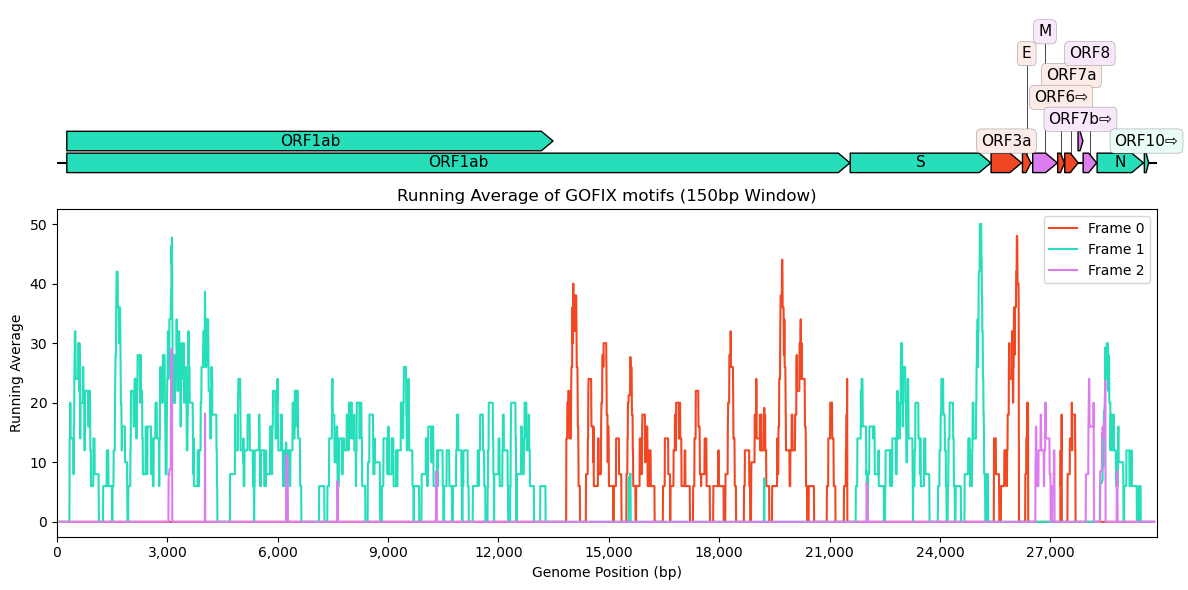

In [66]:
#whole genome
x_positions_frame_1 = [i * 3 + (window_size // 2) for i in range(len(gofix_scores[0]))]
x_positions_frame_2 = [i * 3 + (window_size // 2) for i in range(len(gofix_scores[1]))]
x_positions_frame_3 = [i * 3 + (window_size // 2) for i in range(len(gofix_scores[2]))]
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12, 6), sharex=True,
                               gridspec_kw={"height_ratios": [1, 2]})
graphic_record.plot(ax=ax1, with_ruler=False, strand_in_label_threshold=7)
ax2.plot(x_positions_frame_1, gofix_scores[0], label="Frame 0",color=color_dict[0])
ax2.plot(x_positions_frame_2, gofix_scores[1], label="Frame 1",color=color_dict[1])
ax2.plot(x_positions_frame_3, gofix_scores[2], label="Frame 2",color=color_dict[2])
ax2.set_ylabel("Running Average")
ax2.set_xlabel("Genome Position (bp)")
ax2.legend()
ax2.set_title("Running Average of GOFIX motifs (150bp Window)")

plt.tight_layout()
plt.show()

75

In [22]:
seq.features

[SeqFeature(CompoundLocation([FeatureLocation(ExactPosition(265), ExactPosition(13468), strand=1), FeatureLocation(ExactPosition(13467), ExactPosition(21555), strand=1)], 'join'), type='CDS', location_operator='join'),
 SeqFeature(FeatureLocation(ExactPosition(265), ExactPosition(13483), strand=1), type='CDS'),
 SeqFeature(FeatureLocation(ExactPosition(21562), ExactPosition(25384), strand=1), type='CDS'),
 SeqFeature(FeatureLocation(ExactPosition(25392), ExactPosition(26220), strand=1), type='CDS'),
 SeqFeature(FeatureLocation(ExactPosition(26244), ExactPosition(26472), strand=1), type='CDS'),
 SeqFeature(FeatureLocation(ExactPosition(26522), ExactPosition(27191), strand=1), type='CDS'),
 SeqFeature(FeatureLocation(ExactPosition(27201), ExactPosition(27387), strand=1), type='CDS'),
 SeqFeature(FeatureLocation(ExactPosition(27393), ExactPosition(27759), strand=1), type='CDS'),
 SeqFeature(FeatureLocation(ExactPosition(27755), ExactPosition(27887), strand=1), type='CDS'),
 SeqFeature(Fea

In [23]:
orf1ab = graphic_record.crop([0,21555])

In [70]:
for gf in orf1ab.features:
    gf.color = color_dict[feature_frames[gf.label]]

In [24]:
print(21555//3)

7185


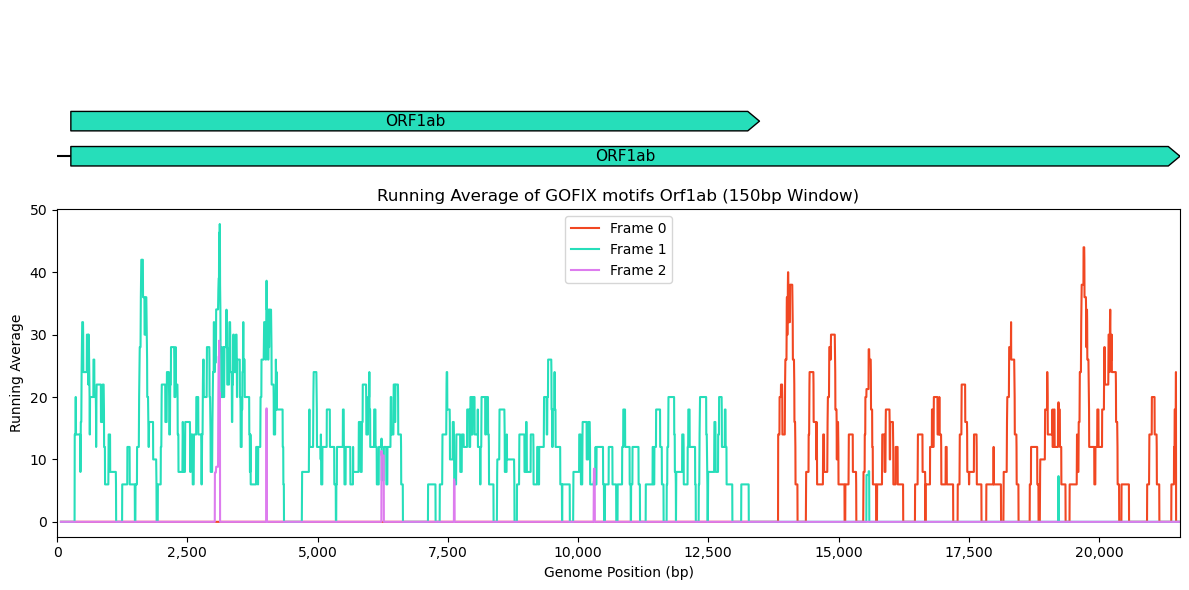

In [71]:
#orf1ab
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12, 6), sharex=True,
                               gridspec_kw={"height_ratios": [1, 2]})
orf1ab.plot(ax=ax1, with_ruler=False, strand_in_label_threshold=7)
ax2.plot(x_positions_frame_1[0:7185], gofix_scores[0][0:7185], label="Frame 0",color=color_dict[0])
ax2.plot(x_positions_frame_2[0:7185], gofix_scores[1][0:7185], label="Frame 1",color=color_dict[1])
ax2.plot(x_positions_frame_3[0:7185], gofix_scores[2][0:7185], label="Frame 2",color=color_dict[2])
ax2.set_ylabel("Running Average")
ax2.set_xlabel("Genome Position (bp)")
ax2.legend()
ax2.set_title("Running Average of GOFIX motifs Orf1ab (150bp Window)")

plt.tight_layout()
plt.show()

In [55]:
print(21562//3)
print(25384//3)

7187
8461


In [26]:
spike = graphic_record.crop([21562,25384])

In [72]:
for gf in spike.features:
    gf.color = color_dict[feature_frames[gf.label]]

In [27]:
spike.features

[GF(S, 21562-25384 (1))]

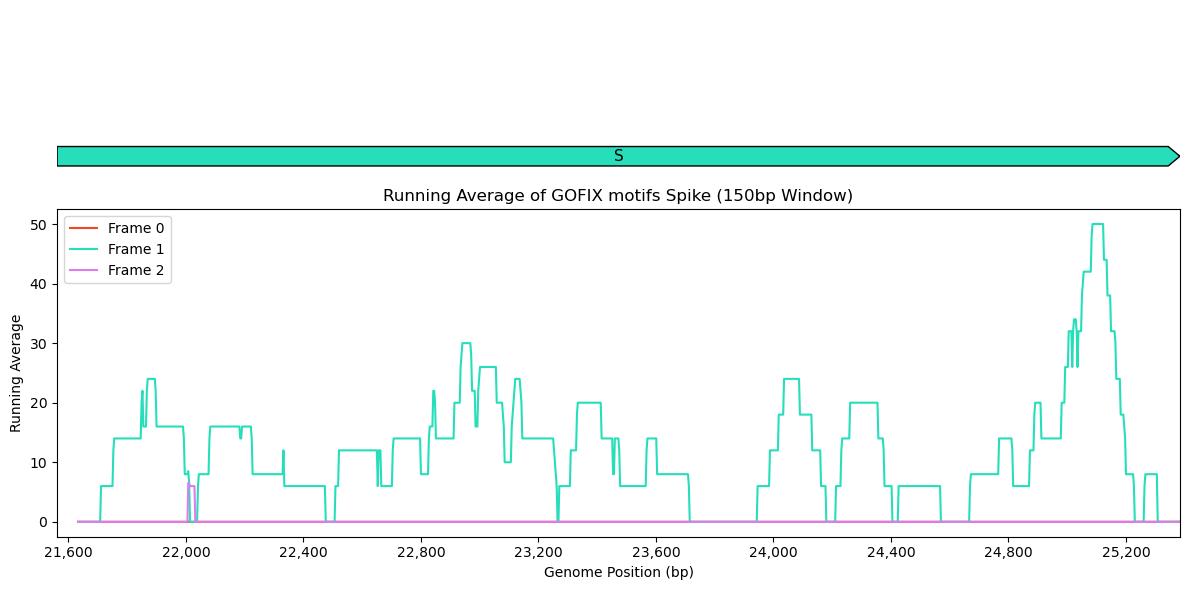

In [73]:
#spike
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12, 6), sharex=True,
                               gridspec_kw={"height_ratios": [1, 2]})
spike.plot(ax=ax1, with_ruler=False, strand_in_label_threshold=7)
ax2.plot(x_positions_frame_1[7186:8461], gofix_scores[0][7186:8461], label="Frame 0",color=color_dict[0])
ax2.plot(x_positions_frame_2[7186:8461], gofix_scores[1][7186:8461], label="Frame 1",color=color_dict[1])
ax2.plot(x_positions_frame_3[7186:8461], gofix_scores[2][7186:8461], label="Frame 2",color=color_dict[2])
ax2.set_ylabel("Running Average")
ax2.set_xlabel("Genome Position (bp)")
ax2.legend()
ax2.set_title("Running Average of GOFIX motifs Spike (150bp Window)")

plt.tight_layout()
plt.show()

In [63]:
print(25392//3)
print(29750//3)

8464
9916


In [29]:
structural = graphic_record.crop([25392,29750])

In [74]:
for gf in structural.features:
    gf.color = color_dict[feature_frames[gf.label]]

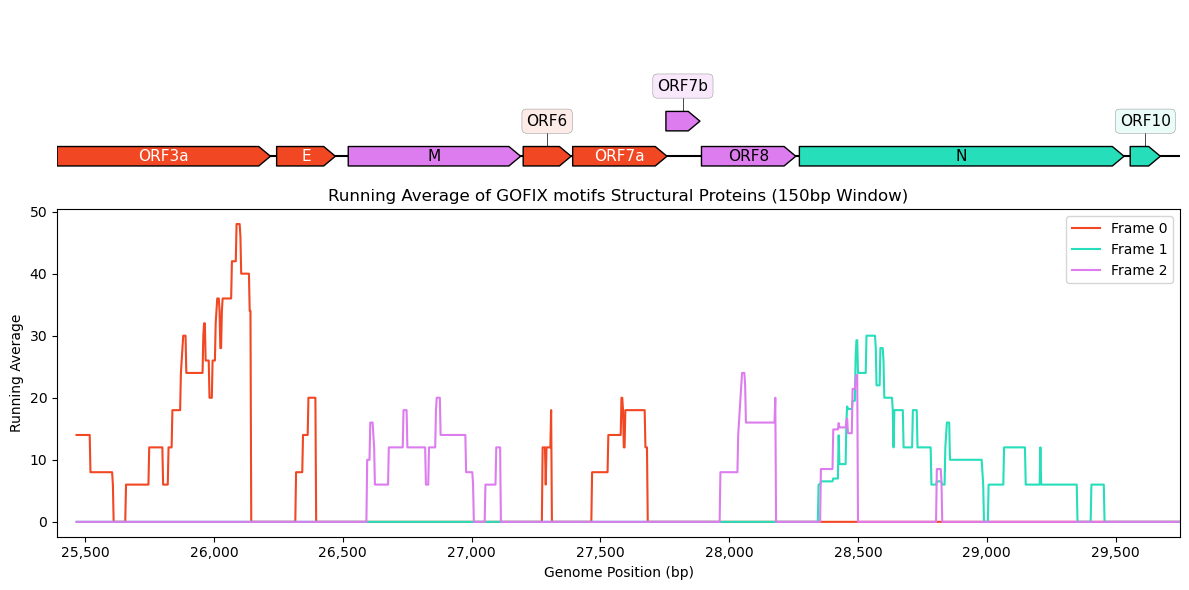

In [75]:
#structural genes
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12, 6), sharex=True,
                               gridspec_kw={"height_ratios": [1, 2]})
structural.plot(ax=ax1, with_ruler=False, strand_in_label_threshold=7)
ax2.plot(x_positions_frame_1[8464:9916], gofix_scores[0][8464:9916], label="Frame 0",color=color_dict[0])
ax2.plot(x_positions_frame_2[8464:9916], gofix_scores[1][8464:9916], label="Frame 1",color=color_dict[1])
ax2.plot(x_positions_frame_3[8464:9916], gofix_scores[2][8464:9916], label="Frame 2",color=color_dict[2])
ax2.set_ylabel("Running Average")
ax2.set_xlabel("Genome Position (bp)")
ax2.legend()
ax2.set_title("Running Average of GOFIX motifs Structural Proteins (150bp Window)")

plt.tight_layout()
plt.show()

In [47]:
for f in seq.features:
    print(f.qualifiers['gene'],f.location.start%3)

['ORF1ab'] 1
['ORF1ab'] 1
['S'] 1
['ORF3a'] 0
['E'] 0
['M'] 2
['ORF6'] 0
['ORF7a'] 0
['ORF7b'] 2
['ORF8'] 2
['N'] 1
['ORF10'] 1


In [76]:
#TODO: Graph reverse strand

In [77]:
rev_seq = seq.seq.reverse_complement()

In [78]:
rev_orf_list = find_orfs(str(rev_seq))

In [79]:
rev_orf_list

{0: [(63, 219),
  (3561, 3723),
  (8865, 9060),
  (10047, 10191),
  (11718, 11925),
  (15876, 15999),
  (16353, 16545),
  (29211, 29388)],
 1: [(562, 697),
  (2899, 3100),
  (4096, 4318),
  (6466, 6706),
  (12964, 13105),
  (15844, 15994),
  (16630, 16789),
  (19726, 19864),
  (21544, 21667),
  (22078, 22216),
  (28333, 28513),
  (29236, 29482)],
 2: [(2132, 2264),
  (2693, 2870),
  (4661, 4805),
  (5792, 5978),
  (6581, 6830),
  (9998, 10139),
  (11579, 11753),
  (12275, 12398),
  (14747, 14912),
  (17417, 17621),
  (20954, 21107),
  (23414, 23717),
  (24881, 25031),
  (25445, 25580),
  (27446, 27614),
  (28214, 28376)]}

In [80]:
rev_raw_scores = get_scores(str(rev_seq),rev_orf_list,window_size)

In [81]:
rev_gofix_scores = {}
frame_set = set([0,1,2])
lf_debug = []
array_range = min([len(rev_raw_scores[f]) for f in rev_raw_scores.keys()])
for frame in rev_raw_scores:
    new_score = []
    #Score is XL_f
    for i,score in enumerate(range(array_range)):
        #Need to calculate l_f
        l_f = window_size
        for other_frame in frame_set - set([frame]):
            l_f -= rev_raw_scores[other_frame][i] * np.max(frame_array[other_frame][(i*3)+other_frame:(i*3)+window_size])
        new_score.append((100/l_f)*rev_raw_scores[frame][i])
        lf_debug.append(l_f)
    rev_gofix_scores[frame] = np.array(new_score)

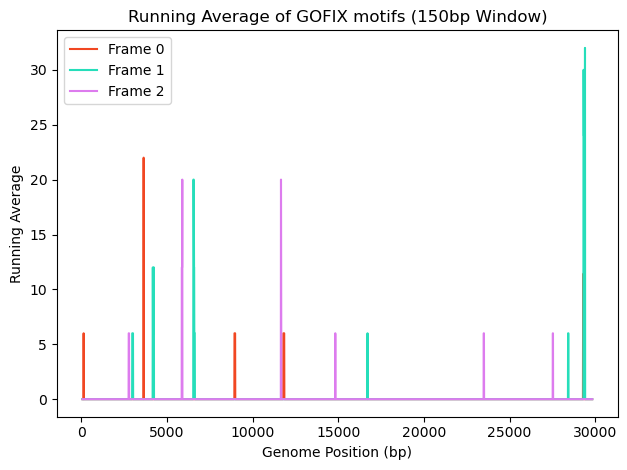

In [82]:
#whole genome
rev_x_positions_frame_1 = [i * 3 + (window_size // 2) for i in range(len(rev_gofix_scores[0]))]
rev_x_positions_frame_2 = [i * 3 + (window_size // 2) for i in range(len(rev_gofix_scores[1]))]
rev_x_positions_frame_3 = [i * 3 + (window_size // 2) for i in range(len(rev_gofix_scores[2]))]
plt.plot(rev_x_positions_frame_1, rev_gofix_scores[0], label="Frame 0",color=color_dict[0])
plt.plot(rev_x_positions_frame_2, rev_gofix_scores[1], label="Frame 1",color=color_dict[1])
plt.plot(rev_x_positions_frame_3, rev_gofix_scores[2], label="Frame 2",color=color_dict[2])
plt.ylabel("Running Average")
plt.xlabel("Genome Position (bp)")
plt.legend()
plt.title("Running Average of GOFIX motifs (150bp Window)")

plt.tight_layout()
plt.show()

In [84]:
str(rev_seq[29236: 29482].translate())

'MATSSFITVLTKKNLAVSHWYFAHMRDKDTKCLTTTTVLNAFEFCYQLNHNMTMRCSSSIRTFDEHIGLFKLRQNAFFNFY*'